# Workflow & Hyperparameter Optimization

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Import the house price data set. We will keep only numerical features for the sake of simplicity

🎯 Your goal will be to fit the best KNN Regressor. In particular, how many "neighbors" (<font color=blue>K</font> in <font color=blue>K</font>NN) should you consider to get the best predictions for your house prices ?

In [10]:
# Load raw data
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv')

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

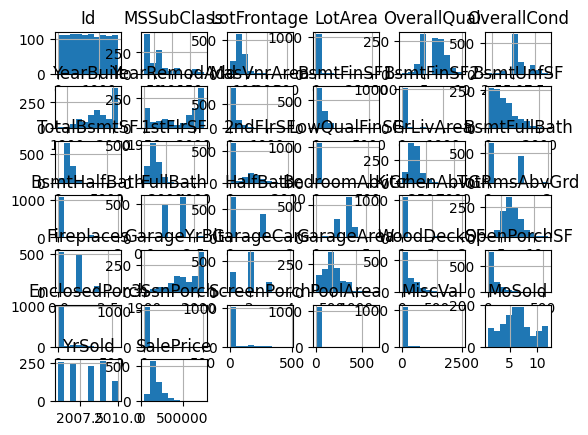

In [11]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']
data.hist()

## 1. Train/Test split

❓ **Question (Holdout)**❓

👇 Split the dataset to create your `X_train` `X_test` and `y_train` `y_test`. Use:
- `test_size=0.3`
- `random_state=0` to compare your results with your buddy

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3)
X_train = train_data.drop(columns=['SalePrice'])
y_train = train_data['SalePrice']
X_test = test_data.drop(columns=['SalePrice'])
y_test = test_data['SalePrice']

## 2. Scaling

⚖️ Scaling is always crucially important for the KNN algorithm..

❓ **Question (Scaling)** ❓ 

* Scale your train set and test set.
* Here, let's simply apply the `StandardScaler` and not waste time choosing one scaler per feature. Indeed, the goals of this exercise are to:
    * review KNN
    * understand GridSearchCV
    * understand RandomizedSearchCV

In [13]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

s_scaler = StandardScaler()

X_train_scaler = s_scaler.fit(X_train)
X_train_scaled = X_train_scaler.transform(X_train)

X_test_scaled = s_scaler.transform(X_test)




## 3. Baseline KNN model

❓ **Question (A baseline for our KNN)** ❓

Cross-validate (*cv = 5*) a simple KNN regressor taking into account only _the closest neighbor_, and compute the average score over the 5 folds.

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor


model = KNeighborsRegressor(n_neighbors = 1)

cv_results = cross_validate(model, X_train_scaled, y_train, cv=5)

cv_results['test_score']

rescaled_score = cv_results['test_score'].mean()
rescaled_score


0.5478819404195453

## 4. GridSearch

### 4.1. A first GridSearch

❓ **Question (GridSearch v1)**❓

Let's use SKLearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start a coarse-grain approach, with `n_neighbors` = [1,5,10,20,50]
- 5-fold cross-validate each parameter
- Make sure to maximize your performance time using `n_jobs`

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

 
# Instanciate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors' : [1,5,10,20,50]}

# Instanciate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1) # paralellize computation


In [17]:
# Fit data to Grid Search
print(search.fit(X_train_scaled,y_train))

# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]}, scoring='r2')
0.7240381528159214
{'n_neighbors': 10}
KNeighborsRegressor(n_neighbors=10)


❓ **Question (best parameters)** ❓

According to the GridSearch, what is the optimal K value?

In [18]:
# YOUR CODE HERE
best_k = 20

❓ **Question (scoring)** ❓ What is the best score the optimal K value produced?

In [19]:
# YOUR CODE HERE
best_score = 0.7457478024650055


### 4.2. A second GridSearch

❓ **Question (GridSearch V2)** ❓


Now, we have an idea about where the best $K$ lies, but some of the values we didn't try could result in a  better performance.

* Re-run a GridSearch trying some values for $K$ around to your previous best value
* What are the `best_score` and `best_k` for this refined GridSearch?

In [21]:
# Instanciate model
model = KNeighborsRegressor()

# Hyperparameter Grid
grid = {'n_neighbors' : [14,15,16,17,18,19,21,22,23,24]}

# Instanciate Grid Search
search = GridSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1) # paralellize computation
search.fit(X_train_scaled,y_train)

# Best score
print(search.best_score_)

# Best Params
search.best_params_

# Best estimator
print(search.best_estimator_)

best_score = 0.7654109746207102 

0.7274831353593842
KNeighborsRegressor(n_neighbors=14)


***🧪 Test your code***

In [25]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write(
print(result.check()))



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Gauthier/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Gauthier/code/gauthieret/data-workflow/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



TypeError: ChallengeResult.write() takes 1 positional argument but 2 were given

### 4.3. Visual check (manual GridSearch)

☝️ This problem is actually simple enough to perform a GridSearch manually.

❓ **Question(Manual GridSearch)** ❓

- Loop manually over all values of $K$ from $1$ to $50$ and store the average of the cross-validated scores of each model in a list.
- Plot the scores as a function of $K$ to visually find the best $K$ using the `Elbow Method`

❓Can you guess what makes GridSearchCV a better option than such manual loop ?


<details>
    <summary>Answer</summary>

- Sklearn's `n_jobs=-1` allows you to paralellize the search, utilizing all of your CPU cores
- What if you had multiple hyper-parameters to co-optimize?
</details>

## 5. GridSearch with multiple parameters

👩🏻‍🏫 KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p` 

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Question (tuning multiple parameters)** ❓


* Use GridSearchCV to search for the best $K$ and $p$ simultaneously.
    * Try all combinations for $K = [1, 5, 10, 20, 50]$ and $p = [1, 2, 3]$. 

In [26]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

grid = {'n_neighbors' : [14,15,16,17,18,19,21,22,23,24], 'p' : [1,2,3] }

search = GridSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1)

search.fit(X_train_scaled,y_train)
print(search.best_score_)
search.best_params_
print(search.best_estimator_)

0.7585682599123826
KNeighborsRegressor(n_neighbors=15, p=1)


❓ **Question (number of submodels)**❓

How many submodels did you train overall?

<details>
    <summary>Hint</summary>

Much more than 15. Think twice :)
    <details>
    <summary>Answer</summary>

75 models due to CV=5
</details>

In [27]:
number_of_submodels = 5*15

❓ **Question (best parameters and best score after tuning the model with multiple parameters)**❓

What are the *best parameters* and the *best score*?

In [28]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

grid = {'n_neighbors' : np.linspace(1,20,20,dtype = int), 'p' : [1,2,3] }

search = GridSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1)

search.fit(X_train_scaled,y_train)
print(search.best_score_)
search.best_params_
print(search.best_estimator_)

0.7899938006333876
KNeighborsRegressor(n_neighbors=2, p=1)


## 6. Random Search

Now let's see whether a RandomizedSearch can find a better combination with the same number of models being fitted.

❓ **Question (RandomizedSearchCV)** ❓

Use `RandomizedSearchCV` to
- Randomly sample $K$ from a uniform `randint(1,50)` distribition
- Sample $p$ from a list $[1,2,3]$
- Use the correct numbers of `n_iter` and `cv` to fit the exact same numbers of models as in your previous GridSearchCV.

In [32]:
from sklearn.model_selection import RandomizedSearchCV
model = KNeighborsRegressor()

grid = {'n_neighbors' : np.random.randint(1,25,20, dtype=int), 'p' : [1,2,3] }

search = RandomizedSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1)

search.fit(X_train_scaled,y_train)
print(search.best_score_)
search.best_params_
print(search.best_estimator_)

0.7696962255988303
KNeighborsRegressor(n_neighbors=8, p=1)


## 7. Generalization

❓ **Question (finetuning your model one more time)**❓

- Refine your RandomsearchCV if you want
- Choose your best model

Now try to display your `cv_results` as a `DataFrame`, this will help you visualize what's going on inside the CV! 😉

In [44]:
from sklearn.model_selection import RandomizedSearchCV
model = KNeighborsRegressor()

grid = {'n_neighbors' : np.random.randint(8,13,5, dtype=int), 'p' : [1,2,3] }

search_best = RandomizedSearchCV(model, grid, scoring = 'r2', cv = 5, n_jobs=-1, n_iter = 75)


search_best.fit(X_train_scaled,y_train)
search.best_score_
search.best_params_
search.best_estimator_

pd.DataFrame(search.cv_results_)
search.cv_results_['mean_test_score'].mean()

/Users/Gauthier/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 15 is smaller than n_iter=75. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.7276901978145282

❓ **Question (Evaluation of the "best" model)** ❓

* Time has come to discover our model's performance with "best params" on the **unseen** test set `X_test`.
    * Compute the r2 score for the test set and save it as `r2_test`.

In [49]:
r2_test = search_best.score(X_test_scaled, y_test)

❓ **Question (Taking a step back)** ❓

Would you consider the optimized model to generalize well?

<details><summary>Answer</summary>

Test score may decrease a bit with train set. Probably not more than 5%. This can be due to
- A non-representative train/test split
- A cross-val number too small leading to overfitting the model-tuning phase. The more you cross-validated, the more robust your findings will generalize - but you can't increase cv too much if your dataset is too small as you won't keep enough observations in each fold to be representative.
- Our dataset is very small and our hyperparameter optimization is thus extremely dependent (and overfitting) on our train/test split. Always make sure your dataset is much bigger than the total number of hyperparameter combinations you are trying out!
    
</details>

***🧪 Test your code***

In [50]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test =r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/Gauthier/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/Gauthier/code/gauthieret/data-workflow/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.11s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Congratulations! Now, you know how to finetune a model using either a GridSearchCV or a RandomizedSearchCV 

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge!